In [118]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from binance.client import Client
import math
import plotly.graph_objects as go
import plotly.express as px

In [4]:
f = open('config.json')
config = json.load(f)

client = Client(config["api_key"], config["secure_key"])
print("Connected to Binance successfully....")

Connected to Binance successfully....


In [5]:
# Set the time period and number of standard deviations for the calculations
time_period = 20
num_std_dev = 2

In [6]:
klines = client.get_historical_klines(config["currency"], Client.KLINE_INTERVAL_5MINUTE, "1 day ago UTC")

klines_dataframe = pd.DataFrame(
    klines, 
    columns=[
        'Open Time', 
        'Open', 
        'High', 
        'Low', 
        'Close', 
        'Volume',
        'Close Time',
        'Quote Asset',
        'Volume',
        'Number of Trades',
        'Taker buy base asset volume',
        'Taker buy quote asset volume'
    ])

In [7]:
display(klines_dataframe)

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote Asset,Volume,Number of Trades,Taker buy base asset volume,Taker buy quote asset volume
0,1671001800000,1322.83000000,1323.58000000,1322.80000000,1323.01000000,513.55510000,1671002099999,679483.84324500,612,273.22980000,361515.36297500,0
1,1671002100000,1323.02000000,1324.67000000,1322.00000000,1324.25000000,750.14110000,1671002399999,992914.21419100,1082,414.13760000,548174.95773900,0
2,1671002400000,1324.24000000,1324.44000000,1323.44000000,1324.32000000,411.50640000,1671002699999,544864.60428100,559,233.91910000,309723.01161200,0
3,1671002700000,1324.32000000,1324.96000000,1323.69000000,1324.74000000,630.01760000,1671002999999,834360.66609500,638,352.45520000,466751.87062100,0
4,1671003000000,1324.73000000,1324.73000000,1322.27000000,1322.63000000,803.42100000,1671003299999,1063124.46247000,1008,362.06730000,479085.50620600,0
...,...,...,...,...,...,...,...,...,...,...,...,...
283,1671086700000,1291.50000000,1291.57000000,1290.56000000,1290.78000000,294.19780000,1671086999999,379854.42807100,331,141.45860000,182631.93878100,0
284,1671087000000,1290.78000000,1292.13000000,1289.58000000,1289.85000000,520.00340000,1671087299999,671289.14418500,515,159.81240000,206293.46316200,0
285,1671087300000,1289.71000000,1290.39000000,1289.49000000,1289.70000000,437.72920000,1671087599999,564613.54317900,342,180.00760000,232176.94500300,0
286,1671087600000,1289.83000000,1291.30000000,1288.94000000,1290.99000000,559.04550000,1671087899999,721197.69292600,567,195.82390000,252607.63002500,0


In [109]:
klines_dataframe.index = np.arange(klines_dataframe.shape[0])


In [101]:
def column(df, column: str):
    x = df[column]
    return x

In [110]:
closing_price = klines_dataframe['Close']
open_price = klines_dataframe['Open']
high_price = klines_dataframe['High']
low_price = klines_dataframe['Low']
close_time = klines_dataframe['Close Time']


closing_price = closing_price.astype(float)
open_price = open_price.astype(float)
low_price = low_price.astype(float)
high_price = high_price.astype(float)

In [111]:
def bollinger_band(close, time_period,num_std_dev):
    # Calculate the rolling mean and standard deviation
    rolling_mean = close.rolling(time_period).mean()
    rolling_std = close.rolling(time_period).std()
    rolling_mean.fillna(0)
    rolling_std.fillna(0)

    upper_band = rolling_mean + (num_std_dev * rolling_std)
    lower_band = rolling_mean - (num_std_dev * rolling_std)
    upper_band.fillna(0)
    lower_band.fillna(0)

    return rolling_mean,rolling_std,upper_band,lower_band

In [112]:
rolling_mean,rolling_std,upper_band,lower_band = bollinger_band(closing_price, time_period, num_std_dev)

In [113]:
# Set the scale of the x axis
min_time = close_time.min()
max_time = close_time.max()

# Set the scale of the y axis
min_price = math.floor(float(closing_price.min()))
max_price = math.ceil(float(closing_price.max()))


upper_limit = max_price + 10
lower_limit = min_price - 10


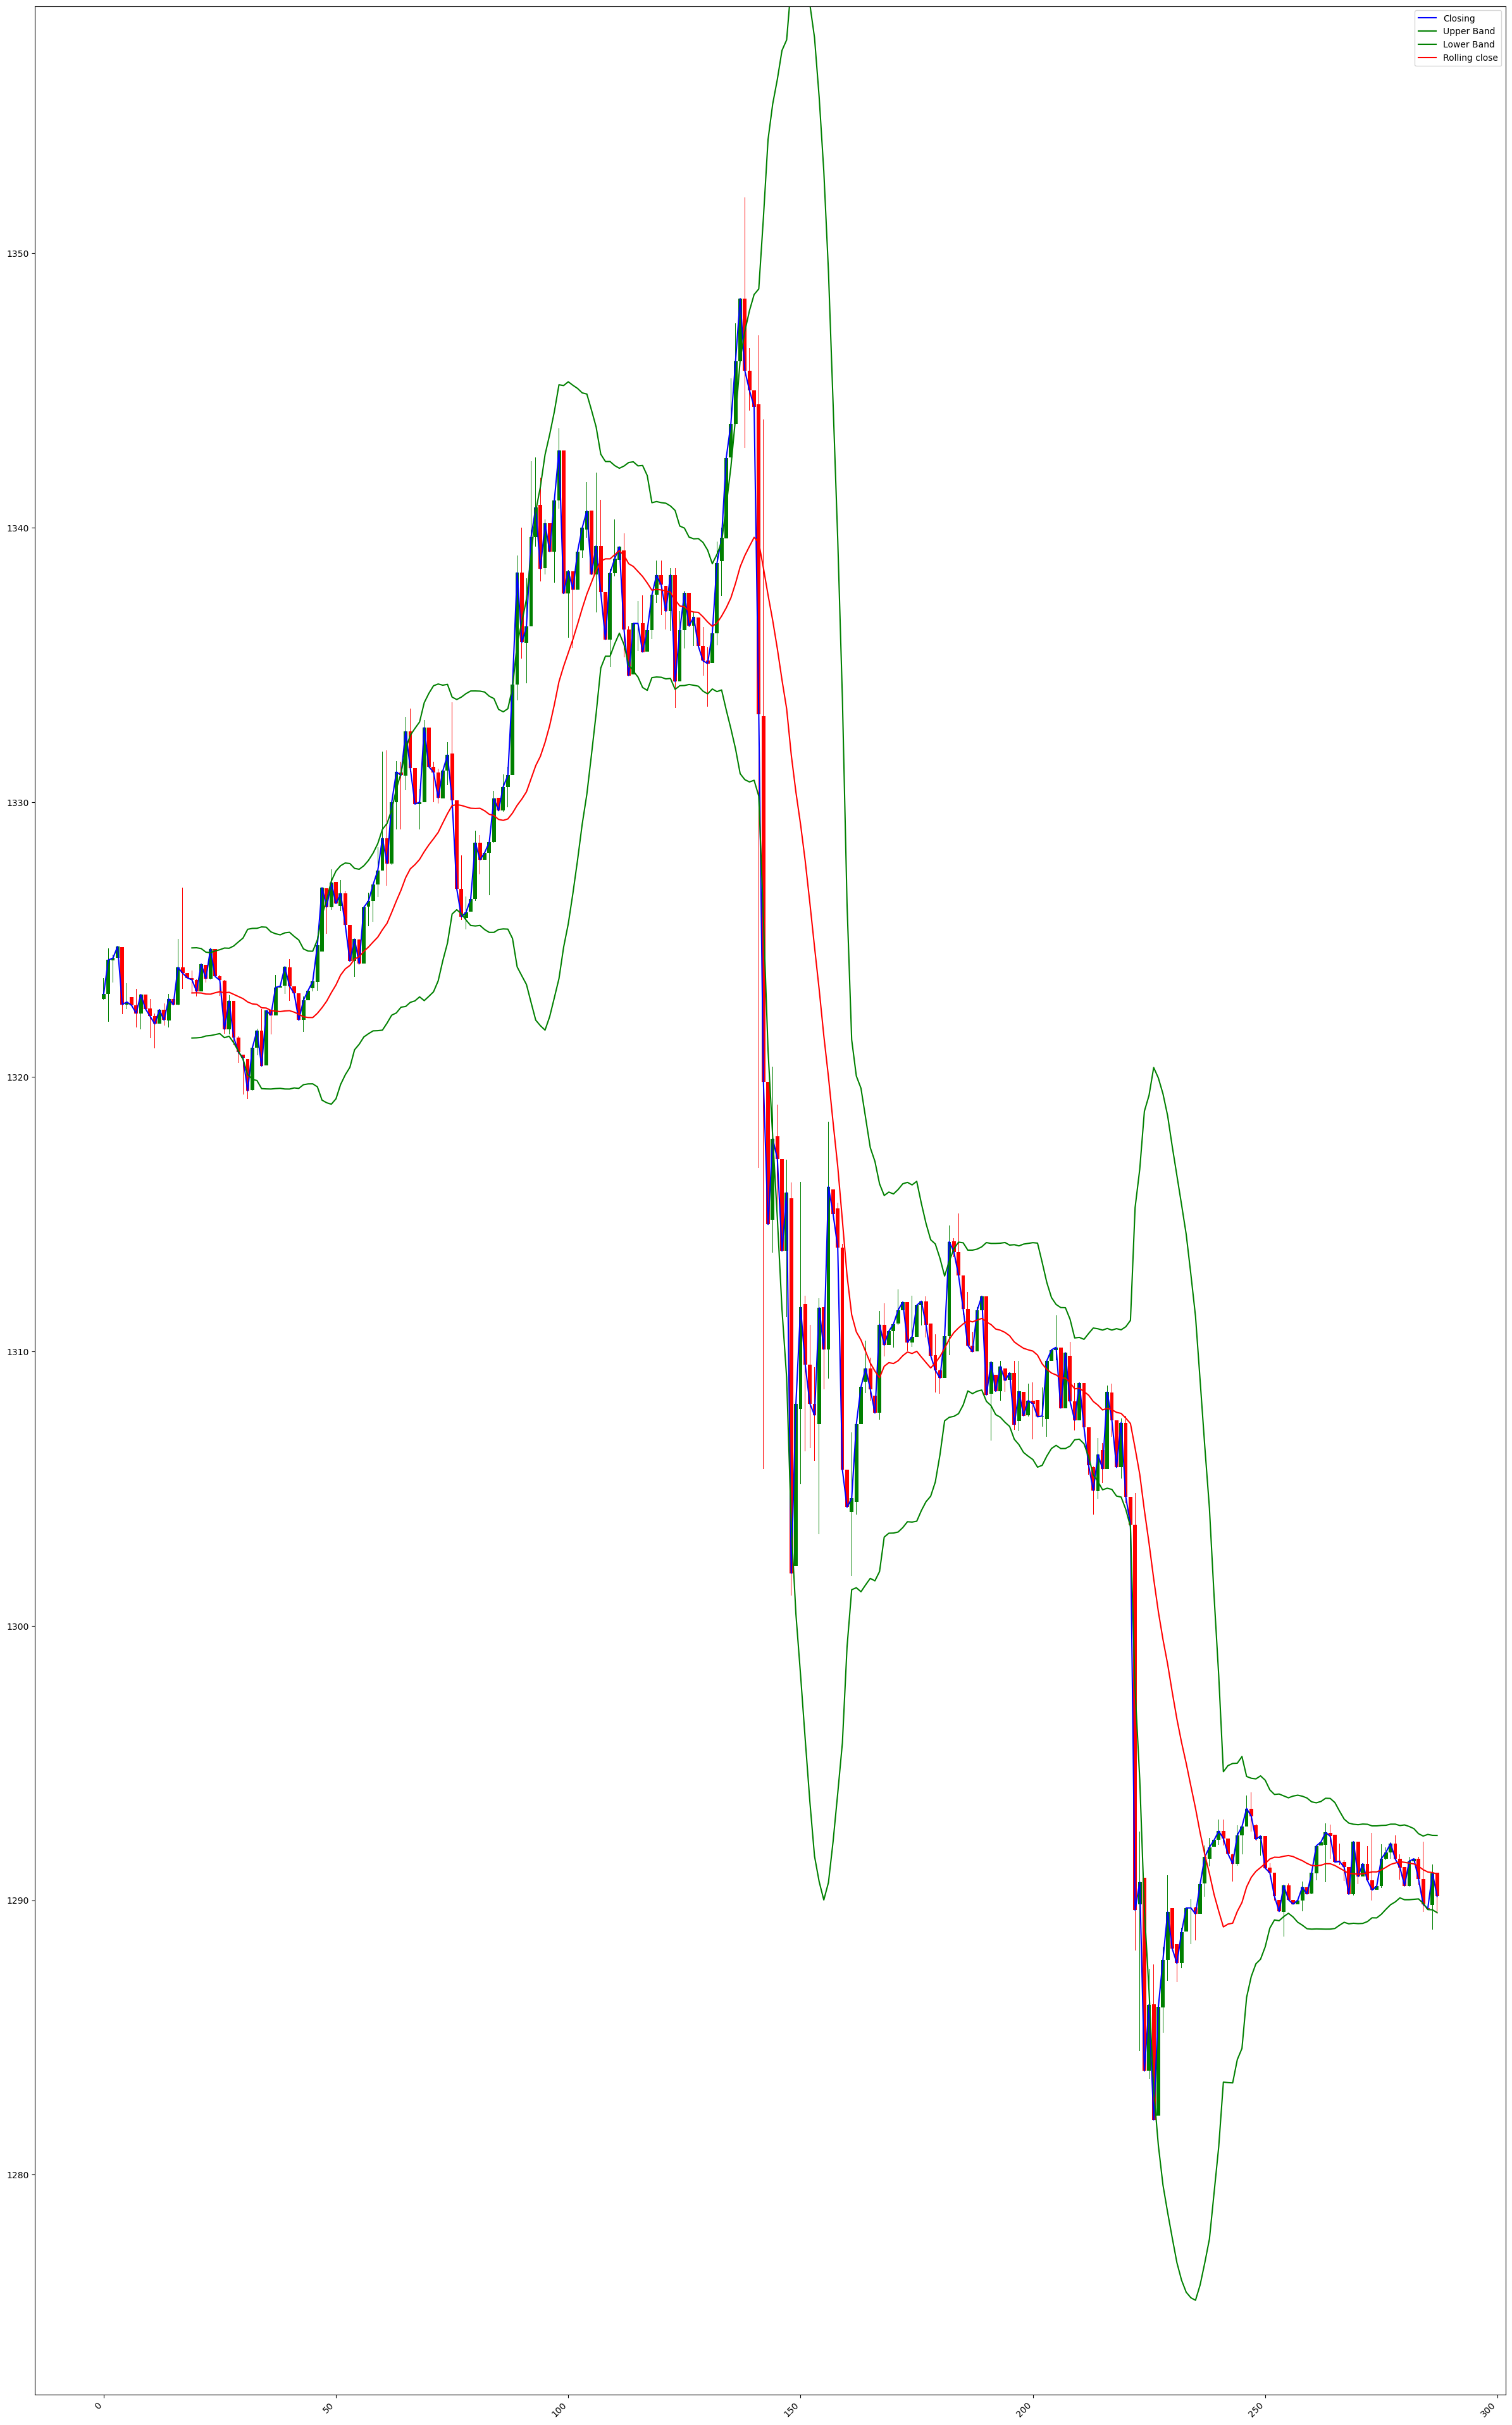

In [141]:
from matplotlib.pyplot import figure



figure(figsize=(30, 50), dpi=100)
plt.plot(upper_band.index,closing_price,color='blue', label='Closing')
plt.plot(upper_band.index,upper_band,color='green', label='Upper Band')
plt.plot(lower_band.index,lower_band,color='green', label='Lower Band')
plt.plot(rolling_mean.index,rolling_mean,color='red', label='Rolling close')
plt.ylim(lower_limit,upper_limit)


#define width of candlestick elements
width = .8
width2 = .1

#define up and down prices
up = klines_dataframe[klines_dataframe.Close>=klines_dataframe.Open]
down = klines_dataframe[klines_dataframe.Close<klines_dataframe.Open]
up= up.astype(float)
down= down.astype(float)

#define colors to use
col1 = 'green'
col2 = 'red'

#plot up prices
plt.bar(up.index,up.Close-up.Open,width,bottom=up.Open,color=col1)
plt.bar(up.index,up.High-up.Close,width2,bottom=up.Close,color=col1)
plt.bar(up.index,up.Low-up.Open,width2,bottom=up.Open,color=col1)

#plot down prices
plt.bar(down.index,down.Close-down.Open,width,bottom=down.Open,color=col2)
plt.bar(down.index,down.High-down.Open,width2,bottom=down.Open,color=col2)
plt.bar(down.index,down.Low-down.Close,width2,bottom=down.Close,color=col2)

#rotate x-axis tick labels
plt.xticks(rotation=45, ha='right')


plt.legend()
plt.show()